# Legal Document Retrieval through Active Learning approaches: A comparative study

### Research Questions

1. How do different AL sampling strategies perform compared to baselines trained on all data available?
    - We will evaluate the performance of AL sampling strategies based on uncertainty and diversity against different baselines.
2. Does the query size significantly impact the performance of the AL sampling strategies?
    - We will evaluate experiment results using different query sizes and AL sampling strategies.
3. What is the impact of the size of the initial labeled samples on the performance of AL sampling strategies?
    - We will evaluate the results of AL sampling strategies using different sizes of initial labeled samples.
4. Does the pool size impact the performance of AL sampling strategies?
    - We will evaluate how unlabeled data's availability impacts AL sampling strategies' performance.
5. Can different data sources from the same domain benefit the AL cycle?
    - We will evaluate using a data source in the AL cycle and the performance acquired on a test set of a different source.

| hyperparameter | description |values |
| --------------- | ------ | ------------|
| AL sampling strategy | TODO | LeastConfidence<br>LeastConfidenceDropout<br>MarginSampling<br>MarginSamplingDropout<br>KCenterGreedy<br>KMeansSampling<br>RandomSampling |
| Query size | TODO | 8, 16, 32, 64 |
| Size of initial labeled samples | TODO |  16, 32, 64, 128 |
| Pool size | TODO | 640, 1280, 2560, 5120 |
| Dataset | TODO | STJ local, IRIS STJ |

In [1]:
import pandas as pd
from IPython.display import display, HTML

In [2]:
data = pd.read_csv('../data/all_runs.csv', sep=";")
nsp_models_data = data[data.tag == 'only_nsp_v0']
nsp_models_data = nsp_models_data[(nsp_models_data.strategy != 'EntropySampling') & (nsp_models_data.strategy != 'EntropySamplingDropout')]
baselines_data = data[data.tag == 'only_baselines_v0']

/opt/miniconda3/envs/deepal/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3442: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
set(nsp_models_data.strategy.values)

{'KCenterGreedy',
 'KMeansSampling',
 'LeastConfidence',
 'LeastConfidenceDropout',
 'MarginSampling',
 'MarginSamplingDropout',
 'RandomSampling'}

In [5]:
set(nsp_models_data.columns.values)

{'_runtime',
 '_step',
 '_timestamp',
 'dataset',
 'initial_labeled_data',
 'model',
 'n_epochs',
 'n_init_labeled',
 'n_initial_unlabeled_pool',
 'n_query',
 'n_round',
 'name',
 'new_labeled_data',
 'predictions',
 'round',
 'samples',
 'seed',
 'strategy',
 'tag',
 'test_accuracy',
 'test_data',
 'total_labeled_data',
 'train_batch_size'}

In [6]:
# pd.options.display.max_rows = None
nsp_models_data[['model','strategy','dataset']].drop_duplicates()

,model,strategy,dataset
77,Legal_BERT_STF,MarginSamplingDropout,IRIS_STJ_LOCAL_STJ
83,BERTikal,MarginSamplingDropout,IRIS_STJ_LOCAL_STJ
89,ITD_BERT,MarginSamplingDropout,IRIS_STJ_LOCAL_STJ
95,BERT,MarginSamplingDropout,IRIS_STJ_LOCAL_STJ
101,Legal_BERT_STF,LeastConfidenceDropout,IRIS_STJ_LOCAL_STJ
...,...,...,...
15655,BERT,LeastConfidence,LOCAL_STJ
15661,Legal_BERT_STF,RandomSampling,LOCAL_STJ
15667,BERTikal,RandomSampling,LOCAL_STJ
15673,ITD_BERT,RandomSampling,LOCAL_STJ


In [7]:
pd.options.display.max_rows = 10

def filter_data(data, dataset, strategy, total_samples, initial_pool, query, train_batch):
    data1 = data[data.dataset == dataset]
    data1 = data1[data1.strategy == strategy]
    data1 = data1[data1.samples == total_samples]
    data1 = data1[data1.n_init_labeled == initial_pool]
    data1 = data1[data1.n_query == query]
    data1 = data1[data1.train_batch_size == train_batch]
    # data1 = data1[data1['round'] == round]
    return data1

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
sns.set(style="whitegrid")

def plot_groupedbar(data, x, y, hue, baseline_data, title_vars, alpha = 0.75):
    g = sns.barplot(x="total_labeled_data",y="test_accuracy",hue='model',data=data)
    g.set_title("Strategy = {} | Total Samples = {} | Initial Pool = {} | Query = {} | Batch Size = {}".format(*title_vars))
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    g.set(ylim=(-0.1, 1))
    for idx, row in baseline_data.iterrows():
        ls=['-','--','-.',':'][idx%4]
        # lw=10-8*idx/len(baseline_data)
        g.axhline(row['test_accuracy'], label=row['model'] +' -> '+ row['strategy'],
                 ls=ls, color=list(mcolors.CSS4_COLORS.keys())[idx], alpha=alpha)

    plt.legend()
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

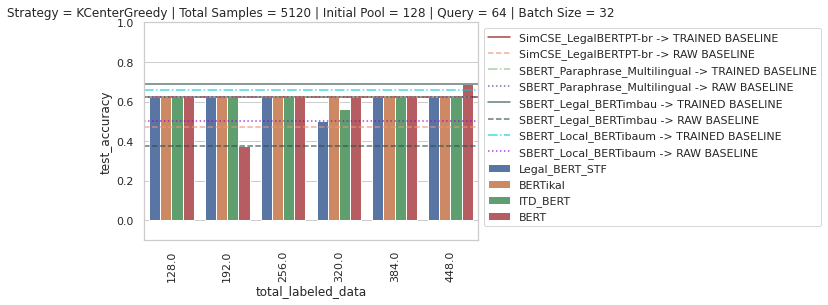

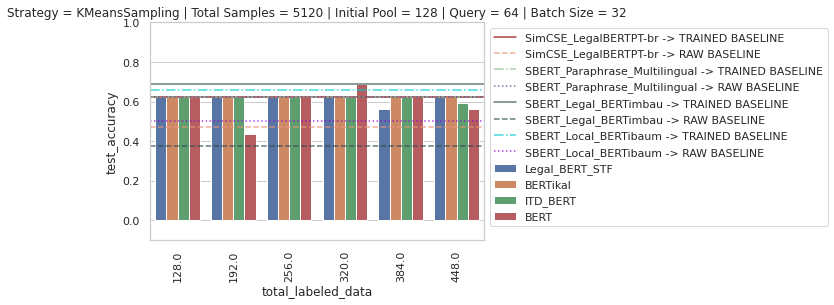

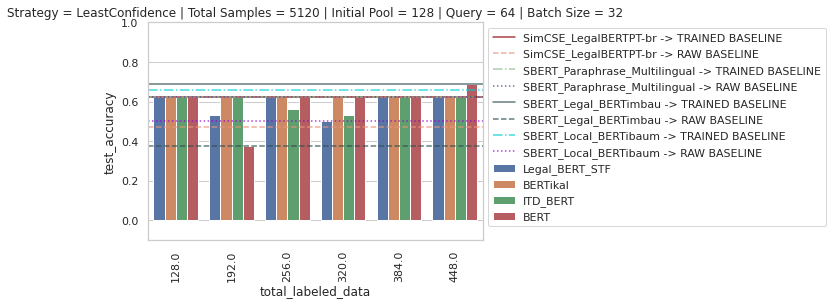

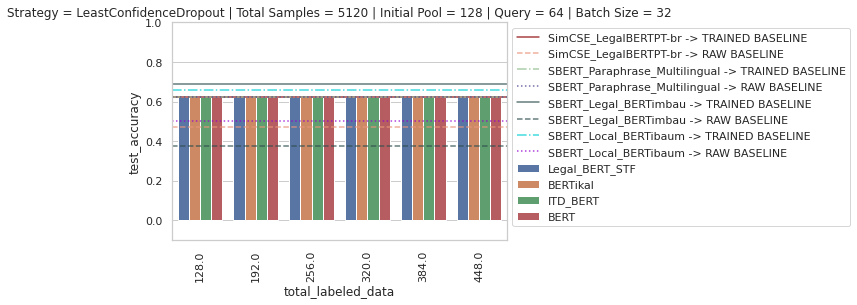

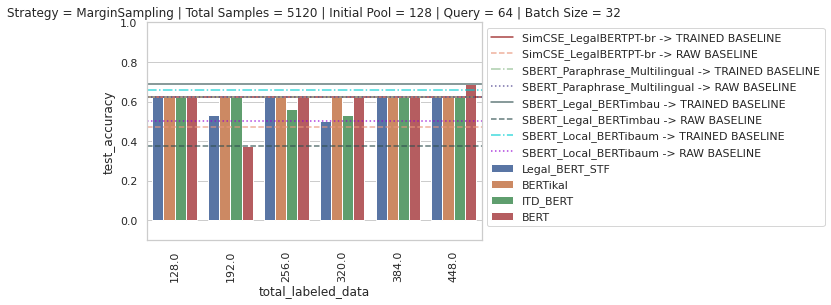

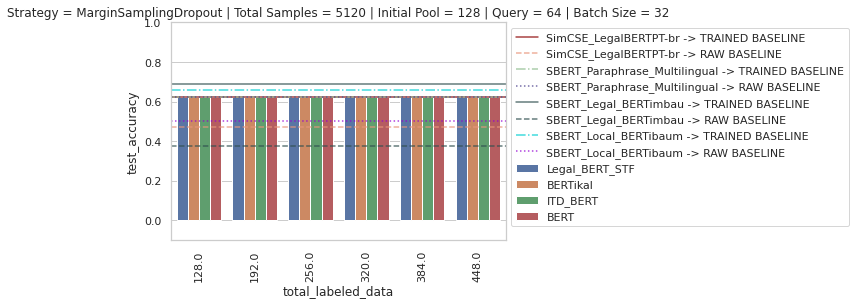

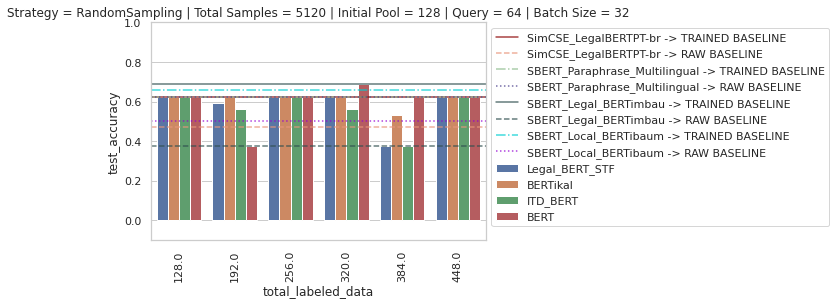

In [9]:
dataset = 'LOCAL_STJ'
strategies = [
 # 'EntropySampling',
 # 'EntropySamplingDropout',
 'KCenterGreedy',
 'KMeansSampling',
 'LeastConfidence',
 'LeastConfidenceDropout',
 'MarginSampling',
 'MarginSamplingDropout',
 'RandomSampling']

total_samples = 5120
initial_pool = 128
query = 64
batch_size = 32

for strategy in strategies:
    
    rs_local_stj = filter_data(nsp_models_data, dataset, strategy, total_samples, initial_pool, query, batch_size)
    b_data = baselines_data[(baselines_data.dataset == dataset) & (baselines_data.samples == total_samples)]
    plot_groupedbar(rs_local_stj, 'total_labeled_data', 'test_accuracy', 'model', b_data, [strategy, total_samples, initial_pool, query, batch_size])

In [10]:
from dash import Dash, dcc, html, Input, Output, clientside_callback
import dash_bootstrap_components as dbc 
from jupyter_dash import JupyterDash
import plotly.express as px
import plotly.graph_objects as go

app = JupyterDash(__name__, 
                  external_stylesheets=[dbc.themes.BOOTSTRAP],
                  external_scripts=[{'src': 'https://cdnjs.cloudflare.com/ajax/libs/html2canvas/1.4.0/html2canvas.min.js'}]
                 )

app.layout = dbc.Container([
    html.H1("Results Analysis Dashboard", className='mb-2', style={'textAlign':'center'}),

    dbc.Row([
        dbc.Col([
            html.Label('Dataset'),
            dcc.Dropdown(
                    id="dataset",
                    options=sorted(list(set(nsp_models_data['dataset'].values))),
                    value=sorted(list(set(nsp_models_data['dataset'].values)))[0],
                    clearable=False,)
            ], width=3),
        dbc.Col([
            html.Label('Pool size'),
            dcc.Dropdown(
                    id="samples",
                    options=sorted(list(set(nsp_models_data['samples'].values))),
                    value=sorted(list(set(nsp_models_data['samples'].values)))[0],
                    clearable=False,)  
        ], width=3)
        ]),
    dbc.Row([
        dbc.Col([
            html.Label('Initial labeled'),
            dcc.Dropdown(
                    id="n_init_labeled",
                    options=sorted(list(set(nsp_models_data['n_init_labeled'].values))),
                    value=sorted(list(set(nsp_models_data['n_init_labeled'].values)))[0],
                    clearable=False,)
            ], width=3),
        dbc.Col([
            html.Label('Query'),
            dcc.Dropdown(
                    id="n_query",
                    options=sorted(list(set(nsp_models_data['n_query'].values))),
                    value=sorted(list(set(nsp_models_data['n_query'].values)))[0],
                    clearable=False,)
            ], width=3),
        
        ]),
    
    dbc.Button(
        'Download as image',
        id='download-image'),
    
    dbc.Card(
            [
                dcc.Graph(id="rs"),
                dcc.Graph(id="ls"),
                dcc.Graph(id="ms"),
                # dcc.Graph(id="es"),
                dcc.Graph(id="km"),
                dcc.Graph(id="kc"),
                dcc.Graph(id="lsd"),
                dcc.Graph(id="msd"),
                # dcc.Graph(id="esd"),
            ],
            body=True,
            id='component-to-save'
        )
])

@app.callback(
    Output("rs", "figure"),
    Output("ls", "figure"), 
    Output("ms", "figure"),
    # Output("es", "figure"),
    Output("km", "figure"),
    Output("kc", "figure"),
    Output("lsd", "figure"),
    Output("msd", "figure"),
    # Output("esd", "figure"),
    
    Input("dataset", "value"),
    Input("samples", "value"),
    Input("n_init_labeled", "value"),
    Input("n_query", "value"),
)
def update_bar_chart(dataset, samples, n_init_labeled, n_query):
    mask1 = nsp_models_data["dataset"] == dataset
    mask2 = nsp_models_data["samples"] == samples
    mask3 = nsp_models_data["n_init_labeled"] == n_init_labeled
    mask4 = nsp_models_data["n_query"] == n_query
    
    nsp_data = nsp_models_data[mask1 & mask2 & mask3 & mask4]
    baseline_data = baselines_data[(baselines_data.dataset == dataset) & (baselines_data.samples == samples)]
    
    output = []
    for strategy in ["RandomSampling", "LeastConfidence","MarginSampling","KMeansSampling","KCenterGreedy",
                "LeastConfidenceDropout","MarginSamplingDropout",]: #"EntropySamplingDropout", "EntropySampling",
        data = nsp_data[nsp_data.strategy == strategy]
        fig = px.bar(data, title=strategy,
                     x='total_labeled_data', y="test_accuracy", 
                     color="model", barmode="group")

        for idx, row in baseline_data.iterrows():
            fig.add_trace(go.Scatter(
                x=(n_init_labeled - (n_query/2),
                   data['total_labeled_data'].max() + (n_query/2)),
                y=(row['test_accuracy'],row['test_accuracy']),
                mode='lines',
                name=row['model'] +' -> '+ row['strategy'],
                yaxis='y1',
                opacity=0.75
            ))
        output.append(fig)
        
    return *output,

clientside_callback(
    """
    function(n_clicks){
        if(n_clicks > 0){
            html2canvas(document.getElementById("component-to-save"), {useCORS: true}).then(function (canvas) {
                var anchorTag = document.createElement("a");
                document.body.appendChild(anchorTag);
                anchorTag.download = "download.png";
                anchorTag.href = canvas.toDataURL();
                anchorTag.target = '_blank';
                anchorTag.click();
            });
        }
    }
    """,
    Output('download-image', 'n_clicks'),
    Input('download-image', 'n_clicks')
)

app.run_server(mode="inline", host='0.0.0.0',debug=True, port=8049)


Dash is running on http://0.0.0.0:8049/



### **Research Question 1**: How do different AL sampling strategies perform compared to baselines trained on all data available?

1. Evaluate charts along the AL rounds, choosing pinning values for other hyperparameters
    * Evaluate AL methods in different pool sizes comparing with the respective raw and trained baselines

2. Evaluate through statistical test, like with https://github.com/mirkobunse/critdd
    * Perform statistical tests for differences in the results of the AL method, dividing only by the pool size

#### 1.1 Evaluate AL methods in different pool sizes comparing with the respective raw and trained baselines

In [11]:
question1_baseline_data = baselines_data[baselines_data.dataset != 'IRIS_STJ_LOCAL_STJ']
question1_nsp_data = nsp_models_data[nsp_models_data.dataset != 'IRIS_STJ_LOCAL_STJ']
question1_results = pd.DataFrame()

In [12]:
for dataset_pool, group in question1_baseline_data.groupby(["dataset","samples"]):
    best_in_group = group.nlargest(2, "test_accuracy")
    question1_results = question1_results.append(best_in_group)

In [13]:
for dataset_pool, group in question1_nsp_data.groupby(["dataset","samples"]):
    best_in_group = group.nlargest(2, "test_accuracy")
    question1_results = question1_results.append(best_in_group)

In [19]:
q1_tmp = question1_results[['dataset', 'samples', 'model', 'strategy', 'n_init_labeled','n_query', 'round','total_labeled_data','test_accuracy']]
for _, group in q1_tmp.groupby(['dataset', 'samples']):
    sorted_group = group.sort_values('test_accuracy', ascending=False)
    display(sorted_group)

,dataset,samples,model,strategy,n_init_labeled,n_query,round,total_labeled_data,test_accuracy
8757,IRIS_STJ,640.0,BERTikal,RandomSampling,128.0,64.0,2.0,256.0,0.658273
8925,IRIS_STJ,640.0,BERTikal,KCenterGreedy,128.0,16.0,2.0,160.0,0.658273
12,IRIS_STJ,640.0,SBERT_Legal_BERTimbau,TRAINED BASELINE,NaN,NaN,NaN,640.0,0.510791
11,IRIS_STJ,640.0,SBERT_Paraphrase_Multilingual,RAW BASELINE,NaN,NaN,NaN,0.0,0.478417


,dataset,samples,model,strategy,n_init_labeled,n_query,round,total_labeled_data,test_accuracy
8037,IRIS_STJ,1280.0,BERTikal,RandomSampling,32.0,8.0,2.0,48.0,0.658273
8229,IRIS_STJ,1280.0,BERTikal,KMeansSampling,16.0,32.0,2.0,80.0,0.658273
5,IRIS_STJ,1280.0,SBERT_Legal_BERTimbau,RAW BASELINE,NaN,NaN,NaN,0.0,0.624101
3,IRIS_STJ,1280.0,SBERT_Paraphrase_Multilingual,RAW BASELINE,NaN,NaN,NaN,0.0,0.606115


,dataset,samples,model,strategy,n_init_labeled,n_query,round,total_labeled_data,test_accuracy
59,LOCAL_STJ,640.0,SBERT_Paraphrase_Multilingual,RAW BASELINE,NaN,NaN,NaN,0.0,0.6875
62,LOCAL_STJ,640.0,SBERT_Local_BERTibaum,TRAINED BASELINE,NaN,NaN,NaN,640.0,0.6875
21540,LOCAL_STJ,640.0,BERT,KCenterGreedy,128.0,64.0,5.0,448.0,0.6875
21564,LOCAL_STJ,640.0,BERT,KMeansSampling,128.0,64.0,5.0,448.0,0.6875


,dataset,samples,model,strategy,n_init_labeled,n_query,round,total_labeled_data,test_accuracy
19807,LOCAL_STJ,1280.0,BERT,KCenterGreedy,64.0,64.0,0.0,64.0,0.71875
19831,LOCAL_STJ,1280.0,BERT,KMeansSampling,64.0,64.0,0.0,64.0,0.71875
52,LOCAL_STJ,1280.0,SBERT_Legal_BERTimbau,TRAINED BASELINE,NaN,NaN,NaN,1280.0,0.68750
54,LOCAL_STJ,1280.0,SBERT_Local_BERTibaum,TRAINED BASELINE,NaN,NaN,NaN,1280.0,0.68750


,dataset,samples,model,strategy,n_init_labeled,n_query,round,total_labeled_data,test_accuracy
44,LOCAL_STJ,2560.0,SBERT_Legal_BERTimbau,TRAINED BASELINE,NaN,NaN,NaN,2560.0,0.71875
3750,LOCAL_STJ,2560.0,Legal_BERT_STF,MarginSamplingDropout,16.0,64.0,1.0,80.0,0.71875
18036,LOCAL_STJ,2560.0,BERT,KMeansSampling,64.0,64.0,5.0,384.0,0.71875
45,LOCAL_STJ,2560.0,SBERT_Legal_BERTimbau,RAW BASELINE,NaN,NaN,NaN,0.0,0.65625


,dataset,samples,model,strategy,n_init_labeled,n_query,round,total_labeled_data,test_accuracy
16257,LOCAL_STJ,5120.0,BERT,RandomSampling,64.0,64.0,2.0,192.0,0.75000
17288,LOCAL_STJ,5120.0,BERT,KCenterGreedy,16.0,64.0,1.0,80.0,0.75000
36,LOCAL_STJ,5120.0,SBERT_Legal_BERTimbau,TRAINED BASELINE,NaN,NaN,NaN,5120.0,0.68750
38,LOCAL_STJ,5120.0,SBERT_Local_BERTibaum,TRAINED BASELINE,NaN,NaN,NaN,5120.0,0.65625


In this analysis we pick the two best results for baselines and AL strategies only grouped by the available pool-size.
One can notice that the adoption of a setup of AL strategy consistently outperforms or reaches performance of baselines in both datasets and pool sizes. The best improvement achieves X% of data usage reduction. 

In concern to IRIS_STJ dataset, it is important to highlight that RandomSampling besides the diversities AL strategies, K-MeansSampling and KCenter-Greedy, using BERTikal as base model gives the best results. 

In the other hand, for LOCAL_STJ dataset, in general, the base model most benefitial of the AL cycle is vanilla BERT model.

#### 1.2 Evaluate through statistical test

In [15]:
from autorank import autorank, plot_stats, create_report, latex_table

In [46]:
for dataset, dataset_grouped in question1_nsp_data.groupby('dataset'):
    for samples, group in dataset_grouped.groupby('samples'):
        print("Dataset: {} - Pool: {}".format(dataset, samples))
        pivoted_group = group.pivot_table(index=['model','n_init_labeled','n_query', 'round'], columns='strategy', values='test_accuracy')
        # display(pivoted_group)        
        # result = autorank(tmp, alpha=0.05, verbose=False)
        # display(result)
        # create_report(result)
        # plot_stats(result)
        # plt.show()
        nan_rows = pivoted_group.isna().any(axis=1)
        df_nan_rows = pivoted_group[nan_rows]
        for column in df_nan_rows.columns[df_nan_rows.isna().any()].tolist():
            print(column)
            setup_nan = list(set(df_nan_rows[df_nan_rows[[column]].isna().any(axis=1)].index.tolist()))
            result = {}
            for model, il, q, r in setup_nan:
                key = "IL: {} - Q: {}".format(il,q)
                result[key] = [model] if key not in result else list(set(result[key] + [model]))
            for k, v in result.items():
                print(k)
                print(v)
            print('-------------------------------------------------------------')
        print('#############################################')

Dataset: IRIS_STJ - Pool: 640.0
#############################################
Dataset: IRIS_STJ - Pool: 1280.0
#############################################
Dataset: LOCAL_STJ - Pool: 640.0
#############################################
Dataset: LOCAL_STJ - Pool: 1280.0
#############################################
Dataset: LOCAL_STJ - Pool: 2560.0
KCenterGreedy
IL: 64.0 - Q: 16.0
['ITD_BERT', 'Legal_BERT_STF', 'BERT', 'BERTikal']
IL: 128.0 - Q: 16.0
['ITD_BERT', 'Legal_BERT_STF', 'BERT', 'BERTikal']
IL: 128.0 - Q: 8.0
['ITD_BERT', 'Legal_BERT_STF', 'BERT', 'BERTikal']
IL: 64.0 - Q: 8.0
['ITD_BERT', 'Legal_BERT_STF', 'BERT', 'BERTikal']
-------------------------------------------------------------
KMeansSampling
IL: 64.0 - Q: 16.0
['ITD_BERT', 'Legal_BERT_STF', 'BERT', 'BERTikal']
IL: 128.0 - Q: 16.0
['ITD_BERT', 'Legal_BERT_STF', 'BERT', 'BERTikal']
IL: 128.0 - Q: 8.0
['ITD_BERT', 'Legal_BERT_STF', 'BERT', 'BERTikal']
IL: 64.0 - Q: 8.0
['ITD_BERT', 'Legal_BERT_STF', 'BERT', 'BERTikal']

In [17]:
set(question1_nsp_data.test_accuracy)

{0.28125,
 0.3125,
 0.34375,
 0.3453237410071942,
 0.3489208633093525,
 0.3507194244604316,
 0.3525179856115107,
 0.3543165467625899,
 0.356115107913669,
 0.3579136690647482,
 0.3597122302158273,
 0.3615107913669064,
 0.3633093525179856,
 0.3651079136690647,
 0.3669064748201439,
 0.368705035971223,
 0.3705035971223021,
 0.3723021582733813,
 0.3741007194244604,
 0.375,
 0.3758992805755395,
 0.3776978417266187,
 0.3794964028776978,
 0.381294964028777,
 0.3830935251798561,
 0.3848920863309352,
 0.3866906474820143,
 0.3884892086330935,
 0.3902877697841727,
 0.3920863309352518,
 0.3938848920863309,
 0.39568345323741,
 0.3974820143884892,
 0.3992805755395683,
 0.4010791366906475,
 0.4028776978417266,
 0.4046762589928057,
 0.40625,
 0.4064748201438849,
 0.408273381294964,
 0.4100719424460431,
 0.4118705035971223,
 0.4136690647482014,
 0.4154676258992806,
 0.4172661870503597,
 0.4190647482014388,
 0.420863309352518,
 0.4244604316546763,
 0.4262589928057554,
 0.4280575539568345,
 0.429856115107